# Handling Main Dataset "coco2014"

In [1]:
!pip install pycocotools
# !pip install --upgrade scikit-image scipy
!pip install torch torchvision opencv-python tqdm
!pip install ultralytics
# !pip install --force-reinstall --no-deps numpy==1.26.4
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
from random import shuffle
from PIL import Image
from pycocotools.coco import COCO

# read form datapath:::>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
dataDir='/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/'
dataType='val2014'
annFile='{}annotations/instances_{}.json'.format(dataDir,dataType)
imageDir = '{}/images/{}/'.format(dataDir, dataType)
# Initialize the COCO api for instance annotations
coco=COCO(annFile)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 9.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.7/872.7 kB 20.2 MB/s eta 0:00:0000:01
loading annotations into memory...
Done (t=8.53s)
creating index...
index created!


In [2]:
'''# number of categories and its content:::>>>>>>>>>>>>>>>>>>>>>>>>>>>>
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)'''

"# number of categories and its content:::>>>>>>>>>>>>>>>>>>>>>>>>>>>>\ncategory_ids = coco.getCatIds()\nnum_categories = len(category_ids)\nprint('number of categories: ',num_categories)\nfor ids in category_ids:\n    cats = coco.loadCats(ids=ids)\n    print(cats)"

# filtered clsses ===>>> 'car', 'bus', 'truck' 

In [3]:
# Get category ids that satisfy the given filter conditions
filterClasses = ['car', 'bus', 'truck']
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
print(catIds)

[3, 6, 8]


#  yolov8n


0: 480x640 2 persons, 2 cars, 1 motorcycle, 1 truck, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


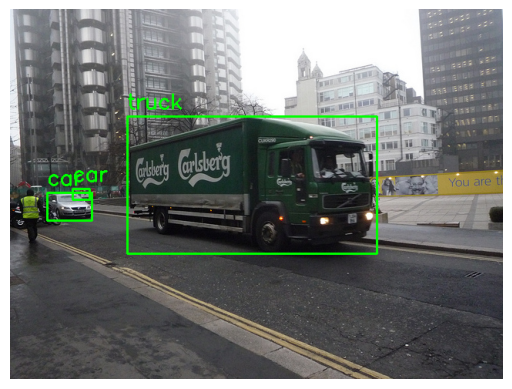

In [20]:
import torch
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

model_yolo = YOLO('yolov8n.pt')  # Pre-trained YOLO model
# print(model)  ############################################################
def detect_objects(image_path):
    img = cv2.imread(image_path)
    original_h, original_w = img.shape[:2]
    
    # Run YOLO on the original image without resizing
    results = model_yolo(img)

    vehicle_classes = ['car', 'bus', 'truck']
    detected_vehicles = []

    # Filter vehicle classes
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls)
            class_name = model_yolo.names[cls_id]
            if class_name in vehicle_classes:
                # Bounding box coordinates
                x1, y1, x2, y2 = box.xyxy[0]

                # Ensure bounding boxes are within the original image's size
                x1 = max(0, min(x1.item(), original_w))
                y1 = max(0, min(y1.item(), original_h))
                x2 = max(0, min(x2.item(), original_w))
                y2 = max(0, min(y2.item(), original_h))

                detected_vehicles.append((x1, y1, x2, y2, class_name))

    return img, detected_vehicles

def draw_bboxes(image_path, detected_vehicles):
    img = cv2.imread(image_path)
    
    # Draw bounding boxes on the original image
    for (x1, y1, x2, y2, class_name) in detected_vehicles:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, class_name, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert BGR to RGB for displaying in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
'''
/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014/COCO_train2014_000000001518.jpg
/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/val2014/COCO_val2014_000000001532.jpg
/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/val2014/COCO_val2014_000000001799.jpg
'''
# Test with uploaded image
image_path = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/val2014/COCO_val2014_000000001799.jpg'
img, detected_vehicles = detect_objects(image_path)
draw_bboxes(image_path, detected_vehicles)



In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import cv2
from sklearn.metrics import f1_score
from ultralytics import YOLO

# Define VehicleClassifier (same as before)
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize YOLO model
model_yolo = YOLO('yolov8n.pt')

# Load the vehicle classifier model
vehicle_classifier = VehicleClassifier(num_classes=3)
optimizer = optim.Adam(vehicle_classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define image preparation for classification
def prepare_classification_image(img, img_size=224):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

# Perform object detection
def detect_objects(image_path, img_size=640):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    results = model_yolo(img)

    vehicle_classes = ['car', 'bus', 'truck']
    detected_vehicles = []

    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls)
            class_name = model_yolo.names[cls_id]
            if class_name in vehicle_classes:
                x1, y1, x2, y2 = box.xyxy[0]
                detected_vehicles.append((x1.item(), y1.item(), x2.item(), y2.item(), class_name))

    return img, detected_vehicles


    

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         1
     class_1       1.00      1.00      1.00         1
     class_2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



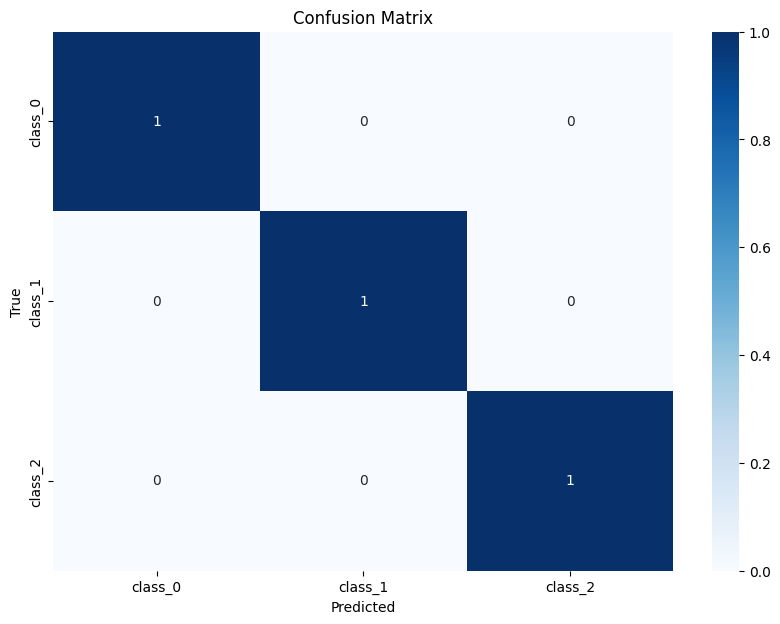

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels and predictions from your classification model
def evaluate_model(true_labels, pred_labels):
    # Print F1 Score
    f1 = f1_score(true_labels, pred_labels, average='macro')
    print(f"F1 Score: {f1}")

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['class_0', 'class_1', 'class_2']))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class_0', 'class_1', 'class_2'], yticklabels=['class_0', 'class_1', 'class_2'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# trial::>>>
true_labels = [0, 1, 2]  # Example true labels
pred_labels = [0, 1, 2]  # Example predicted labels
evaluate_model(true_labels, pred_labels)
